# Sequence to Sequence Modeling

Name: Minghong Zheng
    
UNI: mz2597
    
Email: mz2597@columbia.edu 

**Note**: All code should be in Python3. Keras version should be 2.0.4. The directory structure on the bitbucket repo should be exactly same as the hw4.zip provided to you (with the exception of data directory. Do not upload it). To push the code to remote repo, use the same instructions as given in HW0. **Double check you remote repo for correct directory structure. We won't consider any regrade requests based on wrong directory structure penalty. Again, do not upload data to your bitbucket repo ** <br>
**The data provided to you should not be used for any other purpose than this course. You must not distribute it or upload it to any public platform.**

![title](seq2seq.png)

In this assignment, we are going to solve the problem of summarization using a sequence to sequence model. In a sequence to sequence problem, we have an encoder and a decoder. We feed the sequence of word embeddings to an encoder and train decoder to learn the summaries. We will be seeing 2 types of encoder decoder architectures in this assignment

# Preparing Inputs

The first part of the assignment is to prepare data. You are given training data in train_article.txt, in which each line is the first sentence from an article, and training summary sentences in train_title.txt, which are the corresponding titles of the article. You will be training the model to predict the title of an article given the first sentence of that article, where title generation is a summarization task. Let us limit the maximum vocabulary size to 20000 and maximum length of article to 200 (These are just initial params to get you started and we recommend experimenting, to improve your scores after you are done with your first implementation)

In [2]:
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.layers import Embedding,Dense,Activation
from keras.layers.wrappers import Bidirectional
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

Using TensorFlow backend.


In [3]:
MAX_LEN = 200
VOCAB_SIZE = 20000

Write a function which takes article file, summary file, maximum length of sentence and vocabulary size and does the following
* Create vocabulary: Take most frequent VOCAB_SIZE number of words from article file. Add two special symbols ZERO at start and UNK at end to finally have VOCAB_SIZE + 2 words. Use this array as idx2word. Repeat the process for summary data to create another idx2word corresponding to it. 
* Using the above idx2word for both article and summary data, create word2idx, which will map every word to its index in idx2word array. 
* Convert the words in the article and summary data to their corresponding index from word2idx. If a word is not present in the vocab, use the index of UNK. 
* After the above preprocessing, each sentence in article and summary data should be a list of indices
* Now find the max length of a sentence (which is basically number of indices in a sentence) in article data. Pad every sentence in article data to that length, so that all sentences are of same length. You may use pad_sequences function provided by keras. Do the same for title data.
* return the following outputs transformed article data, vocab size of article data, idx2word(articledata), word2idx(articledata),transformed summary data, vocab size of summary data, idx2word(summarydata), word2idx(summarydata)

In [4]:
import numpy as np
import operator
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences

def load_data(article, summary, max_len, vocab_size):
    #load the text data
    #xdata(article)
    x=[]
    f = open(article, 'r')
    for line in f.readlines():
        line = line.strip()
        x.append(text_to_word_sequence(line,filters=''))
    f.close()
    #ydata(summary)
    y=[]
    f = open(summary, 'r')
    for line in f.readlines():
        line = line.strip()
        y.append(text_to_word_sequence(line,filters=''))
    f.close()
    
    # Create vocabulary with most frequent VOCAB_SIZE number of words from article file
    #xdata(article)
    freqs = {}
    for i in range(len(x)):
        for j in range(len(x[i])):
            freqs[x[i][j]] = freqs.get(x[i][j], 0) + 1 # fetch and increment OR initialize
    sorted_freqs = sorted(freqs.items(), key=operator.itemgetter(1),reverse=True)[:vocab_size]
    X_vocab = [n[0] for n in sorted_freqs]

    #ydata(summary)
    freqs = {}
    for i in range(len(y)):
        for j in range(len(y[i])):
            freqs[y[i][j]] = freqs.get(y[i][j], 0) + 1 # fetch and increment OR initialize
    sorted_freqs = sorted(freqs.items(), key=operator.itemgetter(1),reverse=True)[:vocab_size]
    Y_vocab = [n[0] for n in sorted_freqs]
    #idx2word for X(article)
    X_idx2word =[word for word in X_vocab]
    # Add ZERO at start
    X_idx2word.insert(0, 'ZERO')
    # Add UNK at end 
    X_idx2word.append('UNK')
    X_idx2word=np.array(X_idx2word)    
    
    # create word2idx, which will map every word to its index in idx2word array. 
    X_word2idx = {word:indx for indx, word in enumerate(X_idx2word)}
    
    #idx2word for Y(summary)
    Y_idx2word =[word for word in Y_vocab]
    # Add ZERO at start
    Y_idx2word.insert(0, 'ZERO')
    # Add UNK at end 
    Y_idx2word.append('UNK')
    Y_idx2word=np.array(Y_idx2word)    
  
    # create word2idx, which will map every word to its index in idx2word array. 
    Y_word2idx = {word:indx for indx, word in enumerate(Y_idx2word)}
    
    #transformed article data
    max_length_x=0
    for i in range(len(x)):
        max_length_x=max(max_length_x,len(x[i]))
        for j in range(len(x[i])):
            if x[i][j] in X_word2idx:
                x[i][j] = X_word2idx[x[i][j]]
            else:
                x[i][j] = X_word2idx['UNK']

    if max_length_x<MAX_LEN:
        x = pad_sequences(x, maxlen=max_length_x,padding='post')
    else:
        x = pad_sequences(x, maxlen=max_len,padding='post')


    #transformed summary data
    max_length_y=0
    for i in range(len(y)):
        max_length_y=max(max_length_y,len(y[i]))
        for j in range(len(y[i])):
            if y[i][j] in Y_word2idx:
                y[i][j] = Y_word2idx[y[i][j]]
            else:
                y[i][j] = Y_word2idx['UNK']
                

    if max_length_y<MAX_LEN:
        y = pad_sequences(y, maxlen=max_length_y,padding='post')
    else:
        y = pad_sequences(y, maxlen=max_len,padding='post')

    
    return (x, len(X_vocab)+2, X_idx2word, X_word2idx, y, len(Y_vocab)+2, Y_idx2word, Y_word2idx)
#complete this function using details as above

Now use the above function to load the training data from article and summary (i.e. title) files. Do note that, based on your model architecture, you may need to further one-hot vectorize your input to the model

In [5]:
# TO-DO

transformed_article,vocab_size_article,idx2word_article,word2idx_article,transformed_summary,vocab_size_summary,idx2word_summary,word2idx_summary=load_data('data/train_article.txt', 'data/train_title.txt', MAX_LEN, VOCAB_SIZE)

In [6]:
transformed_article.shape

(50000, 24)

In [7]:
transformed_summary.shape

(50000, 32)

In [8]:
vocab_size_article

20002

In [9]:
vocab_size_summary

20002

# Unidirectional LSTM Encoder Decoder 

Define the parameters for your LSTM encoder decoder model. 

In [10]:
BATCH_SIZE =256
NUM_LAYERS = 4
HIDDEN_DIM = 512
EPOCHS =40


Create a Unidirectional encoder decoder LSTM model in create_model function. The model should have a LSTM Unidirectional layer as encoder and a LSTM decoder.
Use categorical_cross_entropy loss and experiment with different optimizers to improve your score.

In [11]:
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.layers import Embedding,Dense,Activation
from keras.layers.wrappers import Bidirectional
from keras.layers import RepeatVector
from keras.layers import TimeDistributed


def create_UniLSTM(X_vocab_len, X_max_len, y_vocab_len, y_max_len, hidden_size, num_layers):
    # TO-DO
    # create and return the model for unidirectional LSTM encoder decoder
    model = Sequential()

    # Creating encoder network
    model.add(Embedding(X_vocab_len, 1000, input_length=X_max_len, mask_zero=True))
    model.add(LSTM(hidden_size))
    model.add(RepeatVector(y_max_len))

    # Creating decoder network
    for _ in range(num_layers):
        model.add(LSTM(hidden_size, return_sequences=True))
    model.add(TimeDistributed(Dense(y_vocab_len)))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy',
            optimizer='rmsprop',
            metrics=['accuracy'])
    return model



    

# Train the Model

Now that we have everything in place, we can run our model. We recommend training the model in batches instead of training on all 50,000 article-title pairs at once, if you encounter memory contraints

In [12]:
#one hot encode
def process_data(word_sentences, max_len, word_to_ix):
    # Vectorizing each element in each sequence
    sequences = np.zeros((len(word_sentences), max_len, len(word_to_ix)))
    for i, sentence in enumerate(word_sentences):
        for j, word in enumerate(sentence):
            sequences[i, j, word] = 1.
    return sequences

In [13]:
model=create_UniLSTM(vocab_size_article,transformed_article.shape[1],vocab_size_summary,transformed_summary.shape[1],HIDDEN_DIM, NUM_LAYERS)

In [14]:
#shuffle the trainig datset
indices = np.arange(len(transformed_article))
np.random.shuffle(indices)

X = transformed_article[indices]
y = transformed_summary[indices]

In [15]:
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint('./save/attention_model_2.h5', save_weights_only=True,save_best_only=True,monitor='val_loss',verbose=1)


In [21]:
for k in range(1, EPOCHS+1):
    # Training 1000 sequences at a time
    for i in range(0, len(X), 1000):
        if i + 1000 >= len(X):
            i_end = len(X)
        else:
            i_end = i + 1000
        y_sequences = process_data(y[i:i_end], y.shape[1], word2idx_summary)

        print('[INFO] Training model: epoch {}th {}/{} samples'.format(k, i, len(X)))
        model.fit(X[i:i_end], y_sequences, batch_size=BATCH_SIZE, epochs=1, validation_split=0.2)
        


[INFO] Training model: epoch 1th 0/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 10s - loss: 1.9296 - acc: 0.7694 - val_loss: 1.9574 - val_acc: 0.7719
[INFO] Training model: epoch 1th 1000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.9371 - acc: 0.7687 - val_loss: 1.9025 - val_acc: 0.7753
[INFO] Training model: epoch 1th 2000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.8678 - acc: 0.7741 - val_loss: 1.9758 - val_acc: 0.7688
[INFO] Training model: epoch 1th 3000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 9s - loss: 1.9053 - acc: 0.7716 - val_loss: 2.0167 - val_acc: 0.7672
[INFO] Training model: epoch 1th 4000/50000 samples
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [====

In [22]:
model.save_weights('./save/attention_model_2.h5')

# Evaluation using Rouge score 

Now that you have trained the model, load the test data i.e. test_article.txt and corresponding reference titles test_title.txt. Process test_article.txt in the same way as you did your train_article.txt. Then use your model to predict the titles.
When you have your model predicted titles, and the reference titles (test_title.txt) calculate the Rouge score corresponding to your predictions. <br>
You should install rouge by executing "pip3 install rouge". Refer https://pypi.python.org/pypi/rouge/0.2.1 for documentation on how to use the package.

In [10]:
import rouge


In [123]:
#load x_test 
x_test=[]
f = open('data/test_article.txt', 'r')
for line in f.readlines():
    line = line.strip()
    x_test.append(text_to_word_sequence(line,filters=''))
f.close()

for i in range(len(x_test)):
    for j in range(len(x_test[i])):
        if x_test[i][j] in word2idx_article:
            x_test[i][j] = word2idx_article[x_test[i][j]]
        else:
            x_test[i][j] = word2idx_article['UNK']
x_test = pad_sequences(x_test, maxlen=transformed_article.shape[1],padding='post')

            
#y_test

y_test_1=[]
f = open('data/test_title.txt', 'r')
for line in f.readlines():
    line = line.strip()
    y_test_1.append(line)
f.close()
y_test_1=np.array(y_test_1)

In [167]:
# TO-DO 
#prediction
predictions = np.argmax(model.predict(x_test), axis=2)

#change the prediction to sequence
sequences=[]
for prediction in predictions:
    sequence = ' '.join([idx2word_summary[index] for index in prediction if index > 0])
    sequences.append(sequence)
sequences=np.array(sequences)

In [54]:
#print rouge scores
from rouge import Rouge
rouge = Rouge()
scores = rouge.get_scores(y_test_1, sequences,avg="TRUE")
scores

 {'rouge-1': {'f': 0.15043928341944434,
   'p': 0.20254620181405896,
'  'r': 0.12789233479899885},
  'rouge-2': {'f': 0.042202895152472123,
  'p': 0.041305668934240366,
  'r': 0.044509863152720293},
  'rouge-l': {'f': 0.12672212286250798,
  'p': 0.14521771190993878,
  'r': 0.12214681898194941}}


# Tensorboard Visualization 

We recommended training the data in batches because of our tensor constraints. This also presents us with a challenge of visualizing loss function and accuracy change with each epoch. Keras has an inbuilt function called fit_generator which takes in a generator function and gives the required batch for training. Use this Function to load data in batches of 100 for 200 steps_per_epoch. Run the training for 10 epochs. Use Keras callbacks to send data to tensorboad (you can look this up online). 

Once your training is done. Go to command line and run tensorboard. By default Tensorboard opens on 6006 port. Do remember to allow traffic on the same for gcloud (like you did for previous assignment). You can see various metrics depending on what you want to track like loss, accuracy, validation loss and validation accuracy over epochs. Attach the plots of loss and accuracy from the tensorboard display in the notebook

In [144]:
y.shape

(50000, 32)

In [146]:
# TO-DO
from keras.callbacks import TensorBoard
import numpy as np

tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0,
                          write_graph=True, write_images=False)

def tb_generator(X, y, batch_size):
    while True:
        index = np.random.choice(500,1)
        i = index[0]*100
        end = i+100
        X_out = X[i:end]
        Y_seq = process_data(y[i:end], transformed_summary.shape[1], word2idx_summary)

        yield X_out, Y_seq
        
model.fit_generator(tb_generator(X, y,100), epochs=10, steps_per_epoch=200,callbacks=[tensorboard])

Epoch 1/10
200/200 [==============================] - 192s - loss: 2.1575 - acc: 0.7626   
Epoch 2/10
200/200 [==============================] - 191s - loss: 1.9008 - acc: 0.7733   
Epoch 3/10
200/200 [==============================] - 191s - loss: 1.8266 - acc: 0.7762   
Epoch 4/10
200/200 [==============================] - 191s - loss: 1.8235 - acc: 0.7742   
Epoch 5/10
200/200 [==============================] - 191s - loss: 1.7950 - acc: 0.7764   
Epoch 6/10
200/200 [==============================] - 191s - loss: 1.7793 - acc: 0.7770   
Epoch 7/10
200/200 [==============================] - 191s - loss: 1.7581 - acc: 0.7781   
Epoch 8/10
200/200 [==============================] - 192s - loss: 1.7438 - acc: 0.7790   
Epoch 9/10
200/200 [==============================] - 192s - loss: 1.7216 - acc: 0.7800   
Epoch 10/10
200/200 [==============================] - 192s - loss: 1.7036 - acc: 0.7804   


### Accuarcy

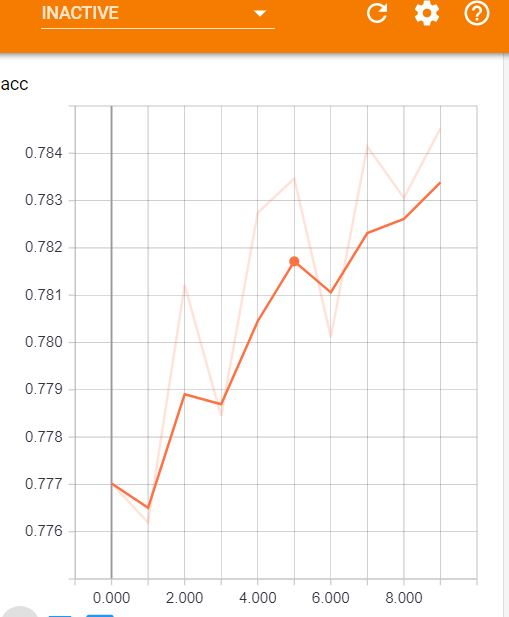

In [149]:
from IPython.display import Image
Image(filename='accuracy.png',width=400,height=400)

### Loss

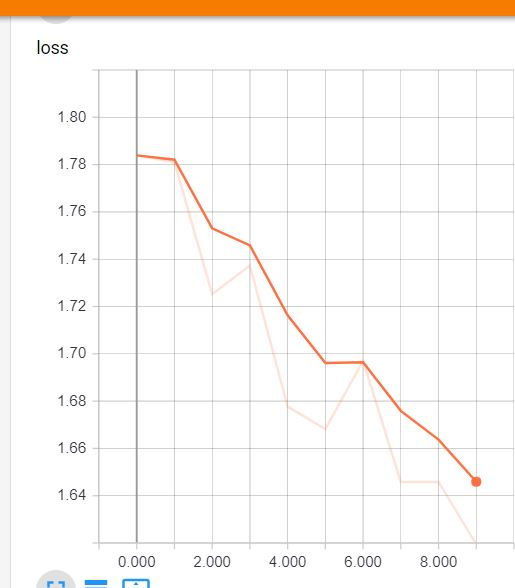

In [150]:
Image(filename='loss.png',width=400,height=400)

# Unidirectional LSTM Encoder Decoder With Attention 

Define the parameters for your LSTM encoder decoder model with attention

You would've observed that the summaries are not yet perfect. This is because in encoder decoder architecture, only the final state of encoder is used to calculate the probabilities. We now move to a more general approach called attention based approach. In this, we take a weighted sum of all weights of encoder instead of just the last one. You are already provided an attention_decoder.py file with AttentionDecoder. Add this layer on top of your encoder and run the same experiment as before. For this part, you don't need to worry about return_probabilities argument to create_UniLSTMwithAttention function. Just pass it as an argument to your attention decoder layer. When return_probabilities is false, the attention decoder returns prediction model, which is what you need for this part of the assignment. When return_probabilities is true, the attention decoder returns the probability model, which you will be using later in the Analysis part of this assignment

Tune Parameters

In [24]:
BATCH_SIZE = 200
NUM_LAYERS =3
HIDDEN_DIM = 128
EPOCHS =22
VOCA_SIZE=10500

Load the Data

In [25]:
transformed_article,vocab_size_article,idx2word_article,word2idx_article,transformed_summary,vocab_size_summary,idx2word_summary,word2idx_summary=load_data('data/train_article.txt', 'data/train_title.txt', MAX_LEN, VOCA_SIZE)

In [26]:

transformed_article.shape

(50000, 24)

In [27]:
transformed_summary.shape

(50000, 32)

In [30]:
from attention_decoder import AttentionDecoder

In [31]:
def create_UniLSTMwithAttention(X_vocab_len, X_max_len, y_vocab_len, y_max_len, hidden_size, num_layers, return_probabilities = False):
    # TO-DO
    # create and return the model for unidirectional LSTM encoder decoder
    model = Sequential()

    # Creating encoder network
    model.add(Embedding(X_vocab_len, HIDDEN_DIM, input_length=X_max_len, mask_zero=True))
    model.add(LSTM(HIDDEN_DIM,return_sequences=True))
    #model.add(RepeatVector(y_max_len))
    model.add(AttentionDecoder(HIDDEN_DIM, y_vocab_len))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
    # create and return the model for unidirectional LSTM encoder decoder with attention
    return model

# Train the Model

Train the model, as you did before, for the model without attention

change both training x and y to the max len 32

In [35]:
#shuffle the data
indices = np.arange(len(transformed_article))
np.random.shuffle(indices)

X = transformed_article[indices]
y = transformed_summary[indices]

In [36]:
# TO-DO
#compile the model
model=create_UniLSTMwithAttention(vocab_size_article,max_len,vocab_size_summary,max_len,HIDDEN_DIM, NUM_LAYERS)

In [37]:
#padd them into the same leangth for X training dataset
max_len=max(transformed_article.shape[1],transformed_summary.shape[1])
X_train=pad_sequences(X, max_len,padding='post')



In [42]:
#save the model weights
checkpoint = ModelCheckpoint('./save/attention_model_3.h5', save_weights_only=True,save_best_only=True,monitor='val_loss',verbose=1)

# Training 1000 sequences at a time
for i in range(0, len(X_train), 1000):
    if i + 1000 >= len(X_train):
        i_end = len(X_train)
    else:
        i_end = i + 1000
    y_sequences = process_data(y[i:i_end], y.shape[1], word2idx_summary)

    model.fit(X_train[i:i_end], y_sequences, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=2,validation_split=0.3,callbacks=[checkpoint])

Train on 700 samples, validate on 300 samples
Epoch 1/22
Epoch 00000: val_loss improved from inf to 9.13418, saving model to ./save/attention_model_3.h5
25s - loss: 9.1949 - acc: 0.4361 - val_loss: 9.1342 - val_acc: 0.5202
Epoch 2/22
Epoch 00001: val_loss improved from 9.13418 to 7.81386, saving model to ./save/attention_model_3.h5
20s - loss: 8.8863 - acc: 0.5281 - val_loss: 7.8139 - val_acc: 0.5202
Epoch 3/22
Epoch 00002: val_loss improved from 7.81386 to 5.05567, saving model to ./save/attention_model_3.h5
19s - loss: 6.3696 - acc: 0.5282 - val_loss: 5.0557 - val_acc: 0.5202
Epoch 4/22
Epoch 00003: val_loss improved from 5.05567 to 4.38950, saving model to ./save/attention_model_3.h5
18s - loss: 4.1941 - acc: 0.5282 - val_loss: 4.3895 - val_acc: 0.5202
Epoch 5/22
Epoch 00004: val_loss did not improve
16s - loss: 3.9174 - acc: 0.5282 - val_loss: 4.6871 - val_acc: 0.5202
Epoch 6/22
Epoch 00005: val_loss did not improve
16s - loss: 3.8289 - acc: 0.5282 - val_loss: 4.5010 - val_acc: 0.5

Epoch 00017: val_loss did not improve
17s - loss: 2.9833 - acc: 0.5452 - val_loss: 4.3195 - val_acc: 0.5246
Epoch 19/22
Epoch 00018: val_loss did not improve
16s - loss: 2.9662 - acc: 0.5466 - val_loss: 4.3358 - val_acc: 0.5238
Epoch 20/22
Epoch 00019: val_loss did not improve
16s - loss: 2.9513 - acc: 0.5473 - val_loss: 4.3457 - val_acc: 0.5278
Epoch 21/22
Epoch 00020: val_loss did not improve
16s - loss: 2.9356 - acc: 0.5461 - val_loss: 4.3667 - val_acc: 0.5259
Epoch 22/22
Epoch 00021: val_loss did not improve
16s - loss: 2.9189 - acc: 0.5470 - val_loss: 4.3909 - val_acc: 0.5228
Train on 700 samples, validate on 300 samples
Epoch 1/22
Epoch 00000: val_loss did not improve
16s - loss: 4.2407 - acc: 0.5471 - val_loss: 4.0572 - val_acc: 0.5528
Epoch 2/22
Epoch 00001: val_loss improved from 4.00041 to 3.97364, saving model to ./save/attention_model_3.h5
18s - loss: 4.0052 - acc: 0.5537 - val_loss: 3.9736 - val_acc: 0.5566
Epoch 3/22
Epoch 00002: val_loss improved from 3.97364 to 3.92610,

Epoch 00017: val_loss did not improve
16s - loss: 2.6927 - acc: 0.5701 - val_loss: 4.3474 - val_acc: 0.5269
Epoch 19/22
Epoch 00018: val_loss did not improve
16s - loss: 2.6656 - acc: 0.5709 - val_loss: 4.3828 - val_acc: 0.5238
Epoch 20/22
Epoch 00019: val_loss did not improve
16s - loss: 2.6403 - acc: 0.5714 - val_loss: 4.4040 - val_acc: 0.5231
Epoch 21/22
Epoch 00020: val_loss did not improve
16s - loss: 2.6133 - acc: 0.5720 - val_loss: 4.4228 - val_acc: 0.5227
Epoch 22/22
Epoch 00021: val_loss did not improve
16s - loss: 2.5895 - acc: 0.5722 - val_loss: 4.4455 - val_acc: 0.5229
Train on 700 samples, validate on 300 samples
Epoch 1/22
Epoch 00000: val_loss did not improve
16s - loss: 4.3548 - acc: 0.5361 - val_loss: 4.3390 - val_acc: 0.5185
Epoch 2/22
Epoch 00001: val_loss did not improve
16s - loss: 4.0728 - acc: 0.5383 - val_loss: 4.1848 - val_acc: 0.5215
Epoch 3/22
Epoch 00002: val_loss did not improve
16s - loss: 3.8141 - acc: 0.5451 - val_loss: 4.0823 - val_acc: 0.5268
Epoch 4/2

Epoch 00017: val_loss did not improve
16s - loss: 2.1687 - acc: 0.6007 - val_loss: 4.2380 - val_acc: 0.5328
Epoch 19/22
Epoch 00018: val_loss did not improve
16s - loss: 2.1193 - acc: 0.6053 - val_loss: 4.2639 - val_acc: 0.5400
Epoch 20/22
Epoch 00019: val_loss did not improve
16s - loss: 2.0631 - acc: 0.6097 - val_loss: 4.2883 - val_acc: 0.5366
Epoch 21/22
Epoch 00020: val_loss did not improve
16s - loss: 2.0075 - acc: 0.6151 - val_loss: 4.3262 - val_acc: 0.5302
Epoch 22/22
Epoch 00021: val_loss did not improve
16s - loss: 1.9565 - acc: 0.6226 - val_loss: 4.3282 - val_acc: 0.5332
Train on 700 samples, validate on 300 samples
Epoch 1/22
Epoch 00000: val_loss did not improve
16s - loss: 4.3428 - acc: 0.5381 - val_loss: 4.1990 - val_acc: 0.5460
Epoch 2/22
Epoch 00001: val_loss did not improve
16s - loss: 4.0125 - acc: 0.5474 - val_loss: 4.0462 - val_acc: 0.5521
Epoch 3/22
Epoch 00002: val_loss did not improve
16s - loss: 3.7158 - acc: 0.5561 - val_loss: 3.9513 - val_acc: 0.5572
Epoch 4/2

Epoch 00019: val_loss did not improve
16s - loss: 1.8231 - acc: 0.6698 - val_loss: 4.2453 - val_acc: 0.5384
Epoch 21/22
Epoch 00020: val_loss did not improve
16s - loss: 1.7709 - acc: 0.6744 - val_loss: 4.2751 - val_acc: 0.5323
Epoch 22/22
Epoch 00021: val_loss did not improve
16s - loss: 1.7234 - acc: 0.6867 - val_loss: 4.2798 - val_acc: 0.5393
Train on 700 samples, validate on 300 samples
Epoch 1/22
Epoch 00000: val_loss did not improve
16s - loss: 4.3259 - acc: 0.5391 - val_loss: 4.2340 - val_acc: 0.5377
Epoch 2/22
Epoch 00001: val_loss did not improve
16s - loss: 4.0055 - acc: 0.5522 - val_loss: 4.1302 - val_acc: 0.5532
Epoch 3/22
Epoch 00002: val_loss did not improve
16s - loss: 3.6908 - acc: 0.5655 - val_loss: 4.0344 - val_acc: 0.5496
Epoch 4/22
Epoch 00003: val_loss did not improve
16s - loss: 3.4064 - acc: 0.5726 - val_loss: 4.0148 - val_acc: 0.5452
Epoch 5/22
Epoch 00004: val_loss did not improve
16s - loss: 3.1659 - acc: 0.5784 - val_loss: 3.9520 - val_acc: 0.5600
Epoch 6/22


Epoch 00021: val_loss did not improve
16s - loss: 1.3789 - acc: 0.7400 - val_loss: 4.5183 - val_acc: 0.5143
Train on 700 samples, validate on 300 samples
Epoch 1/22
Epoch 00000: val_loss did not improve
16s - loss: 4.4123 - acc: 0.5317 - val_loss: 4.3121 - val_acc: 0.5397
Epoch 2/22
Epoch 00001: val_loss did not improve
16s - loss: 4.0469 - acc: 0.5465 - val_loss: 4.2075 - val_acc: 0.5367
Epoch 3/22
Epoch 00002: val_loss did not improve
16s - loss: 3.7010 - acc: 0.5600 - val_loss: 4.1093 - val_acc: 0.5399
Epoch 4/22
Epoch 00003: val_loss did not improve
16s - loss: 3.3821 - acc: 0.5659 - val_loss: 4.0613 - val_acc: 0.5365
Epoch 5/22
Epoch 00004: val_loss did not improve
16s - loss: 3.0996 - acc: 0.5742 - val_loss: 4.0338 - val_acc: 0.5399
Epoch 6/22
Epoch 00005: val_loss did not improve
16s - loss: 2.8513 - acc: 0.5849 - val_loss: 4.0459 - val_acc: 0.5380
Epoch 7/22
Epoch 00006: val_loss did not improve
17s - loss: 2.6431 - acc: 0.5932 - val_loss: 4.0575 - val_acc: 0.5376
Epoch 8/22
Ep

Epoch 00000: val_loss did not improve
16s - loss: 4.2561 - acc: 0.5417 - val_loss: 4.2171 - val_acc: 0.5342
Epoch 2/22
Epoch 00001: val_loss did not improve
16s - loss: 3.8716 - acc: 0.5550 - val_loss: 4.1059 - val_acc: 0.5421
Epoch 3/22
Epoch 00002: val_loss did not improve
16s - loss: 3.4906 - acc: 0.5702 - val_loss: 4.0491 - val_acc: 0.5429
Epoch 4/22
Epoch 00003: val_loss did not improve
16s - loss: 3.1706 - acc: 0.5776 - val_loss: 4.0301 - val_acc: 0.5420
Epoch 5/22
Epoch 00004: val_loss did not improve
16s - loss: 2.8889 - acc: 0.5855 - val_loss: 4.0417 - val_acc: 0.5370
Epoch 6/22
Epoch 00005: val_loss did not improve
16s - loss: 2.6478 - acc: 0.5942 - val_loss: 4.0327 - val_acc: 0.5427
Epoch 7/22
Epoch 00006: val_loss did not improve
16s - loss: 2.4198 - acc: 0.6089 - val_loss: 4.0406 - val_acc: 0.5393
Epoch 8/22
Epoch 00007: val_loss did not improve
16s - loss: 2.2283 - acc: 0.6261 - val_loss: 4.0597 - val_acc: 0.5425
Epoch 9/22
Epoch 00008: val_loss did not improve
16s - loss

Epoch 00002: val_loss did not improve
16s - loss: 3.5922 - acc: 0.5666 - val_loss: 3.9954 - val_acc: 0.5373
Epoch 4/22
Epoch 00003: val_loss did not improve
16s - loss: 3.2704 - acc: 0.5749 - val_loss: 3.9398 - val_acc: 0.5437
Epoch 5/22
Epoch 00004: val_loss did not improve
16s - loss: 2.9713 - acc: 0.5837 - val_loss: 3.9123 - val_acc: 0.5530
Epoch 6/22
Epoch 00005: val_loss did not improve
16s - loss: 2.7005 - acc: 0.5968 - val_loss: 3.9297 - val_acc: 0.5430
Epoch 7/22
Epoch 00006: val_loss did not improve
16s - loss: 2.4742 - acc: 0.6116 - val_loss: 3.9376 - val_acc: 0.5428
Epoch 8/22
Epoch 00007: val_loss did not improve
16s - loss: 2.2777 - acc: 0.6270 - val_loss: 3.9577 - val_acc: 0.5430
Epoch 9/22
Epoch 00008: val_loss did not improve
16s - loss: 2.1099 - acc: 0.6433 - val_loss: 3.9600 - val_acc: 0.5451
Epoch 10/22
Epoch 00009: val_loss did not improve
16s - loss: 1.9654 - acc: 0.6606 - val_loss: 3.9796 - val_acc: 0.5458
Epoch 11/22
Epoch 00010: val_loss did not improve
16s - lo

Epoch 00004: val_loss did not improve
16s - loss: 2.9054 - acc: 0.5857 - val_loss: 4.0317 - val_acc: 0.5552
Epoch 6/22
Epoch 00005: val_loss did not improve
16s - loss: 2.6357 - acc: 0.5982 - val_loss: 4.0119 - val_acc: 0.5528
Epoch 7/22
Epoch 00006: val_loss did not improve
16s - loss: 2.3983 - acc: 0.6125 - val_loss: 4.0242 - val_acc: 0.5481
Epoch 8/22
Epoch 00007: val_loss did not improve
16s - loss: 2.1796 - acc: 0.6329 - val_loss: 4.0439 - val_acc: 0.5492
Epoch 9/22
Epoch 00008: val_loss did not improve
16s - loss: 1.9975 - acc: 0.6541 - val_loss: 4.0596 - val_acc: 0.5524
Epoch 10/22
Epoch 00009: val_loss did not improve
16s - loss: 1.8448 - acc: 0.6711 - val_loss: 4.0858 - val_acc: 0.5513
Epoch 11/22
Epoch 00010: val_loss did not improve
16s - loss: 1.7139 - acc: 0.6879 - val_loss: 4.0999 - val_acc: 0.5443
Epoch 12/22
Epoch 00011: val_loss did not improve
16s - loss: 1.5951 - acc: 0.7067 - val_loss: 4.1248 - val_acc: 0.5426
Epoch 13/22
Epoch 00012: val_loss did not improve
16s - 

Epoch 00006: val_loss did not improve
16s - loss: 2.3650 - acc: 0.6249 - val_loss: 3.9890 - val_acc: 0.5449
Epoch 8/22
Epoch 00007: val_loss did not improve
16s - loss: 2.1596 - acc: 0.6448 - val_loss: 4.0254 - val_acc: 0.5377
Epoch 9/22
Epoch 00008: val_loss did not improve
16s - loss: 1.9822 - acc: 0.6606 - val_loss: 4.0361 - val_acc: 0.5345
Epoch 10/22
Epoch 00009: val_loss did not improve
16s - loss: 1.8247 - acc: 0.6804 - val_loss: 4.0478 - val_acc: 0.5422
Epoch 11/22
Epoch 00010: val_loss did not improve
16s - loss: 1.6923 - acc: 0.7007 - val_loss: 4.0637 - val_acc: 0.5433
Epoch 12/22
Epoch 00011: val_loss did not improve
16s - loss: 1.5699 - acc: 0.7180 - val_loss: 4.0810 - val_acc: 0.5407
Epoch 13/22
Epoch 00012: val_loss did not improve
16s - loss: 1.4591 - acc: 0.7340 - val_loss: 4.0916 - val_acc: 0.5362
Epoch 14/22
Epoch 00013: val_loss did not improve
16s - loss: 1.3615 - acc: 0.7558 - val_loss: 4.1023 - val_acc: 0.5454
Epoch 15/22
Epoch 00014: val_loss did not improve
16s 

Epoch 00008: val_loss did not improve
16s - loss: 1.9957 - acc: 0.6583 - val_loss: 4.0276 - val_acc: 0.5432
Epoch 10/22
Epoch 00009: val_loss did not improve
16s - loss: 1.8334 - acc: 0.6782 - val_loss: 4.0384 - val_acc: 0.5379
Epoch 11/22
Epoch 00010: val_loss did not improve
16s - loss: 1.6953 - acc: 0.7008 - val_loss: 4.0659 - val_acc: 0.5410
Epoch 12/22
Epoch 00011: val_loss did not improve
16s - loss: 1.5759 - acc: 0.7183 - val_loss: 4.0802 - val_acc: 0.5338
Epoch 13/22
Epoch 00012: val_loss did not improve
16s - loss: 1.4702 - acc: 0.7356 - val_loss: 4.1007 - val_acc: 0.5330
Epoch 14/22
Epoch 00013: val_loss did not improve
16s - loss: 1.3674 - acc: 0.7551 - val_loss: 4.1204 - val_acc: 0.5370
Epoch 15/22
Epoch 00014: val_loss did not improve
16s - loss: 1.2743 - acc: 0.7733 - val_loss: 4.1271 - val_acc: 0.5345
Epoch 16/22
Epoch 00015: val_loss did not improve
16s - loss: 1.1909 - acc: 0.7877 - val_loss: 4.1556 - val_acc: 0.5304
Epoch 17/22
Epoch 00016: val_loss did not improve
16

Epoch 00010: val_loss did not improve
16s - loss: 1.6195 - acc: 0.7154 - val_loss: 4.1900 - val_acc: 0.5429
Epoch 12/22
Epoch 00011: val_loss did not improve
16s - loss: 1.4876 - acc: 0.7353 - val_loss: 4.2319 - val_acc: 0.5305
Epoch 13/22
Epoch 00012: val_loss did not improve
16s - loss: 1.3772 - acc: 0.7542 - val_loss: 4.2319 - val_acc: 0.5354
Epoch 14/22
Epoch 00013: val_loss did not improve
16s - loss: 1.2717 - acc: 0.7758 - val_loss: 4.2466 - val_acc: 0.5397
Epoch 15/22
Epoch 00014: val_loss did not improve
16s - loss: 1.1810 - acc: 0.7942 - val_loss: 4.2681 - val_acc: 0.5343
Epoch 16/22
Epoch 00015: val_loss did not improve
16s - loss: 1.1034 - acc: 0.8084 - val_loss: 4.2866 - val_acc: 0.5348
Epoch 17/22
Epoch 00016: val_loss did not improve
16s - loss: 1.0287 - acc: 0.8274 - val_loss: 4.3042 - val_acc: 0.5369
Epoch 18/22
Epoch 00017: val_loss did not improve
16s - loss: 0.9620 - acc: 0.8435 - val_loss: 4.3154 - val_acc: 0.5302
Epoch 19/22
Epoch 00018: val_loss did not improve
16

Epoch 00012: val_loss did not improve
16s - loss: 1.3113 - acc: 0.7660 - val_loss: 4.4158 - val_acc: 0.5232
Epoch 14/22
Epoch 00013: val_loss did not improve
16s - loss: 1.2202 - acc: 0.7861 - val_loss: 4.4231 - val_acc: 0.5204
Epoch 15/22
Epoch 00014: val_loss did not improve
16s - loss: 1.1325 - acc: 0.7995 - val_loss: 4.4509 - val_acc: 0.5134
Epoch 16/22
Epoch 00015: val_loss did not improve
16s - loss: 1.0518 - acc: 0.8186 - val_loss: 4.4760 - val_acc: 0.5241
Epoch 17/22
Epoch 00016: val_loss did not improve
16s - loss: 0.9820 - acc: 0.8317 - val_loss: 4.4706 - val_acc: 0.5164
Epoch 18/22
Epoch 00017: val_loss did not improve
16s - loss: 0.9186 - acc: 0.8470 - val_loss: 4.4981 - val_acc: 0.5215
Epoch 19/22
Epoch 00018: val_loss did not improve
16s - loss: 0.8639 - acc: 0.8600 - val_loss: 4.5137 - val_acc: 0.5187
Epoch 20/22
Epoch 00019: val_loss did not improve
16s - loss: 0.8149 - acc: 0.8690 - val_loss: 4.5170 - val_acc: 0.5142
Epoch 21/22
Epoch 00020: val_loss did not improve
16

Epoch 00014: val_loss did not improve
16s - loss: 1.1727 - acc: 0.8043 - val_loss: 4.3470 - val_acc: 0.5219
Epoch 16/22
Epoch 00015: val_loss did not improve
16s - loss: 1.0884 - acc: 0.8218 - val_loss: 4.3628 - val_acc: 0.5219
Epoch 17/22
Epoch 00016: val_loss did not improve
16s - loss: 1.0125 - acc: 0.8365 - val_loss: 4.3821 - val_acc: 0.5208
Epoch 18/22
Epoch 00017: val_loss did not improve
16s - loss: 0.9468 - acc: 0.8510 - val_loss: 4.3985 - val_acc: 0.5212
Epoch 19/22
Epoch 00018: val_loss did not improve
16s - loss: 0.8912 - acc: 0.8641 - val_loss: 4.4176 - val_acc: 0.5195
Epoch 20/22
Epoch 00019: val_loss did not improve
16s - loss: 0.8399 - acc: 0.8768 - val_loss: 4.4338 - val_acc: 0.5174
Epoch 21/22
Epoch 00020: val_loss did not improve
16s - loss: 0.7877 - acc: 0.8882 - val_loss: 4.4581 - val_acc: 0.5174
Epoch 22/22
Epoch 00021: val_loss did not improve
16s - loss: 0.7422 - acc: 0.9000 - val_loss: 4.4701 - val_acc: 0.5208
Train on 700 samples, validate on 300 samples
Epoch 

Epoch 00016: val_loss did not improve
16s - loss: 0.9751 - acc: 0.8428 - val_loss: 4.1519 - val_acc: 0.5370
Epoch 18/22
Epoch 00017: val_loss did not improve
16s - loss: 0.9137 - acc: 0.8581 - val_loss: 4.1525 - val_acc: 0.5492
Epoch 19/22
Epoch 00018: val_loss did not improve
16s - loss: 0.8638 - acc: 0.8683 - val_loss: 4.1713 - val_acc: 0.5376
Epoch 20/22
Epoch 00019: val_loss did not improve
16s - loss: 0.8118 - acc: 0.8797 - val_loss: 4.1779 - val_acc: 0.5481
Epoch 21/22
Epoch 00020: val_loss did not improve
16s - loss: 0.7680 - acc: 0.8919 - val_loss: 4.1931 - val_acc: 0.5395
Epoch 22/22
Epoch 00021: val_loss did not improve
16s - loss: 0.7226 - acc: 0.9038 - val_loss: 4.2057 - val_acc: 0.5454
Train on 700 samples, validate on 300 samples
Epoch 1/22
Epoch 00000: val_loss did not improve
16s - loss: 4.3339 - acc: 0.5305 - val_loss: 4.3175 - val_acc: 0.5274
Epoch 2/22
Epoch 00001: val_loss did not improve
16s - loss: 3.9008 - acc: 0.5552 - val_loss: 4.2961 - val_acc: 0.5111
Epoch 3/

Epoch 00018: val_loss did not improve
16s - loss: 0.8186 - acc: 0.8760 - val_loss: 4.5602 - val_acc: 0.5124
Epoch 20/22
Epoch 00019: val_loss did not improve
16s - loss: 0.7652 - acc: 0.8901 - val_loss: 4.5807 - val_acc: 0.5120
Epoch 21/22
Epoch 00020: val_loss did not improve
16s - loss: 0.7228 - acc: 0.8972 - val_loss: 4.5954 - val_acc: 0.5086
Epoch 22/22
Epoch 00021: val_loss did not improve
16s - loss: 0.6794 - acc: 0.9109 - val_loss: 4.6068 - val_acc: 0.5107
Train on 700 samples, validate on 300 samples
Epoch 1/22
Epoch 00000: val_loss did not improve
16s - loss: 4.3702 - acc: 0.5309 - val_loss: 4.0814 - val_acc: 0.5486
Epoch 2/22
Epoch 00001: val_loss did not improve
16s - loss: 3.9427 - acc: 0.5494 - val_loss: 4.0306 - val_acc: 0.5367
Epoch 3/22
Epoch 00002: val_loss did not improve
16s - loss: 3.5244 - acc: 0.5681 - val_loss: 3.9612 - val_acc: 0.5466
Epoch 4/22
Epoch 00003: val_loss did not improve
16s - loss: 3.1672 - acc: 0.5860 - val_loss: 3.9316 - val_acc: 0.5452
Epoch 5/22

Epoch 00020: val_loss did not improve
16s - loss: 0.7218 - acc: 0.9013 - val_loss: 4.3884 - val_acc: 0.5337
Epoch 22/22
Epoch 00021: val_loss did not improve
16s - loss: 0.6849 - acc: 0.9152 - val_loss: 4.3970 - val_acc: 0.5451
Train on 700 samples, validate on 300 samples
Epoch 1/22
Epoch 00000: val_loss did not improve
16s - loss: 4.3509 - acc: 0.5371 - val_loss: 4.4719 - val_acc: 0.5228
Epoch 2/22
Epoch 00001: val_loss did not improve
16s - loss: 3.8856 - acc: 0.5567 - val_loss: 4.4179 - val_acc: 0.5234
Epoch 3/22
Epoch 00002: val_loss did not improve
16s - loss: 3.4932 - acc: 0.5736 - val_loss: 4.3795 - val_acc: 0.5228
Epoch 4/22
Epoch 00003: val_loss did not improve
16s - loss: 3.1207 - acc: 0.5925 - val_loss: 4.3370 - val_acc: 0.5260
Epoch 5/22
Epoch 00004: val_loss did not improve
16s - loss: 2.8010 - acc: 0.6065 - val_loss: 4.3278 - val_acc: 0.5224
Epoch 6/22
Epoch 00005: val_loss did not improve
16s - loss: 2.5050 - acc: 0.6248 - val_loss: 4.3307 - val_acc: 0.5275
Epoch 7/22
E

# Evaluation using Rouge Score

Evaluate your model as before, using Rouge score. Ideally, your scores for the model with attention should be better than the model without attention

test dataset

In [44]:
# TO-DO

#x_test 
x_test=[]
f = open('data/test_article.txt', 'r')
for line in f.readlines():
    line = line.strip()
    x_test.append(text_to_word_sequence(line,filters=''))
f.close()

for i in range(len(x_test)):
    for j in range(len(x_test[i])):
        if x_test[i][j] in word2idx_article:
            x_test[i][j] = word2idx_article[x_test[i][j]]
        else:
            x_test[i][j] = word2idx_article['UNK']
x_test = pad_sequences(x_test, max_len,padding='post')

#y_test
y_test_1=[]
f = open('data/test_title.txt', 'r')
for line in f.readlines():
    line = line.strip()
    y_test_1.append(line)
f.close()
y_test_1=np.array(y_test_1)


## prediction

In [47]:
# TO-DO 
#need to write a sequence to predict 5000 samples everytime
predictions = np.argmax(model.predict(x_test), axis=2)


In [50]:
#convert the prediciotn into the sequence
sequences=[]
for prediction in predictions:
    sequence = ' '.join([idx2word_summary[index] for index in prediction if index > 0])
    sequences.append(sequence)
sequences=np.array(sequences)

In [51]:
from rouge import Rouge
rouge = Rouge()
scores = rouge.get_scores(y_test_1, sequences,avg="TRUE")
print(scores)

 {'rouge-1': {'f': 0.1534443495928341,
   'p': 0.23140589625462018,
'  'r': 0.12998859892334798},
  'rouge-2': {'f': 0.052212350289515247,
  'p': 0.060240366305668934,
  'r': 0.048502029398631527},
  'rouge-l': {'f': 0.12850798722122862,
  'p': 0.14938781217711909,
  'r': 0.12194941714681898}}


# Perplexity 

Even though we evaluate our models on ROUGE score, we don't train our neural networks to learn better ROUGE score for the fact that ROUGE score is a complicated nonconvex function. How does our model learn then? In information theory, Perplexity is a measure of how good a model is.

Perplexity                     $$ = 2^{{-\sum _{x}p(x)\log _{2}p(x)}}$$ 
            
Lower the perplexity, better the model. Justify why our model learns well with our loss function? 

#TO-DO

Since the perplexity is always equal to two to the power of the cross entropy, so when cross entropy is low, then the perplexity will be low, and then the model will be better. We are using cross entropy as our loss function, so the lower loss score we get, the better our model will be.  

# Analysis

You will now plot the attention weights for a sentence and it's output. If a grid cell is white in the plot, it means that during summary, the word on x-axis corresponds to the word on y-axis. You are provided with a Visualizer class for helping you out. Make sure you install matplotlib using sudo pip3 install matplotlib and also install python3-tk using sudo apt-get install python3-tk

Reference link: https://github.com/ChunML/seq2seq

In [53]:
import argparse
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

In [119]:
class Visualizer(object):

    def __init__(self):
        """
            Visualizes attention maps
        """
       
    def set_models(self, pred_model, proba_model):
        """
            Sets the models to use
            :param pred_model: the prediction model
            :param proba_model: the model that outputs the activation maps
        """
        self.pred_model = pred_model
        self.proba_model = proba_model

    def attention_map(self, text, padded_data_vec, y_idx_to_word):
        """
            Displays the attention weights graph
            param: input sentence
            param: padded_data_vector for prediction
            param: idx2word dictionary for titles
        """
        input_length = len(text.split())
        
        # get the output sequence
        prediction = np.argmax(pred_model.predict(padded_data_vec), axis=2)[0]
        text_ = text.split()
        valids = [y_idx_to_word[index] for index in prediction if index > 0]
        sequence = ' '.join(valids)
        predicted_text = sequence.split()
        output_length = len(predicted_text)
        #get the weights
        activation_map = np.squeeze(self.proba_model.predict(padded_data_vec))[
            0:output_length, 0:input_length]
        
        plt.clf()
        f = plt.figure(figsize=(8, 8.5))
        ax = f.add_subplot(1, 1, 1)

        # add image
        i = ax.imshow(activation_map, interpolation='nearest', cmap='gray')
        
        # add colorbar
        cbaxes = f.add_axes([0.2, 0, 0.6, 0.03])
        cbar = f.colorbar(i, cax=cbaxes, orientation='horizontal')
        cbar.ax.set_xlabel('Probability', labelpad=2)

        # add labels
        ax.set_yticks(range(output_length))
        ax.set_yticklabels(predicted_text[:output_length])
        
        ax.set_xticks(range(input_length))
        ax.set_xticklabels(text_[:input_length], rotation=45)
        
        ax.set_xlabel('Input Sequence')
        ax.set_ylabel('Output Sequence')

        # add grid and legend
        ax.grid()
        
        f.show()

You can initialize Visualizer class as follows

In [3]:
viz = Visualizer()

Visualizer has two methods.
- set_models 
- attention_map

The set_models takes in prediction model and probability model as inputs. In *create_UniLSTMwithAttention*, the model with *return_probabilities = False* which you already used in the training is the prediction model. For initializing probability model, call *create_UniLSTMwithAttention* with *return_probabilities = True* and initialize the weights with weights of prediction model. Now you can call set_models in this manner:

In [111]:
#compile prob model
prob_model=create_UniLSTMwithAttention(vocab_size_article,max_len,vocab_size_summary,max_len,HIDDEN_DIM, NUM_LAYERS,return_probabilities = True)

In [117]:
#compile pred model
pred_model=model
prob_model.load_weights('./save/attention_model_3.h5')
#set the model
viz.set_models(pred_model,prob_model)

attention_map creates the weights map for you. You need to give a sample sentence, a test_data_vector on which we call call model.predict and your output idx2word dictionary. You can call it as follows

### Visualizations and Description

Use the above Visualizer to visualize attention weights for 15 sentences, as instructed in the Analysis section of the accompanying HW document

#### Good Sentences

### 1)

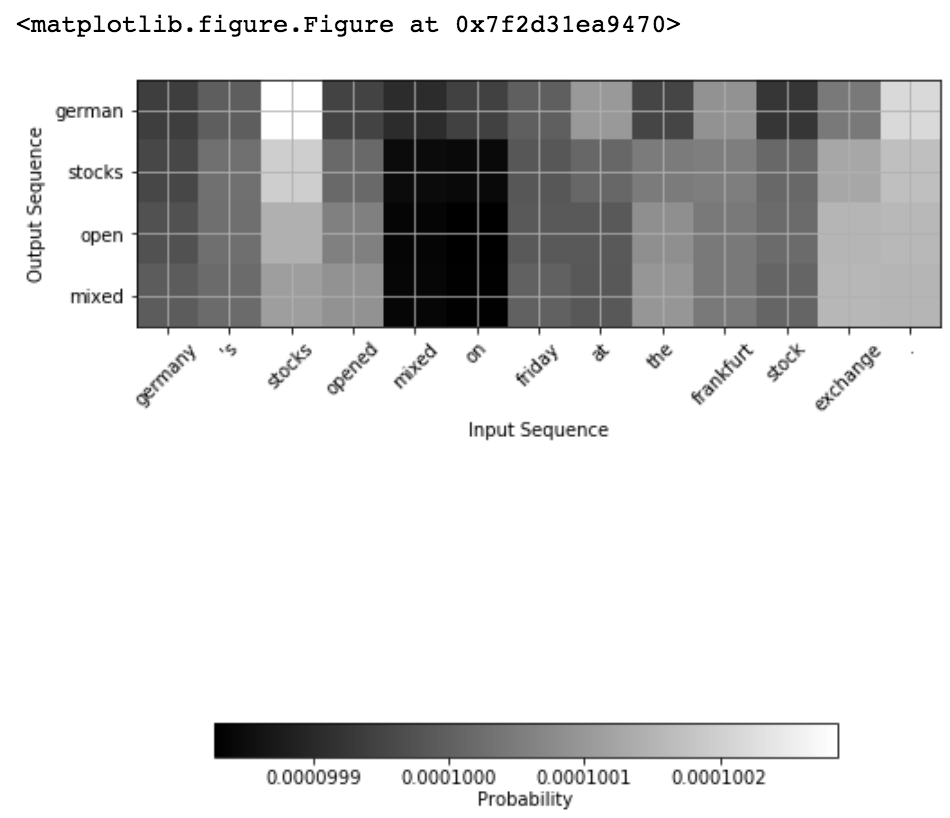

In [152]:
#plot the attion model
text="germany 's stocks opened mixed on friday at the frankfurt stock exchange."
test_data_vector_article=x_test[4249:4250,:]
idx2word_title=idx2word_summary
viz.attention_map(text,test_data_vector_article,idx2word_title)

### 2)

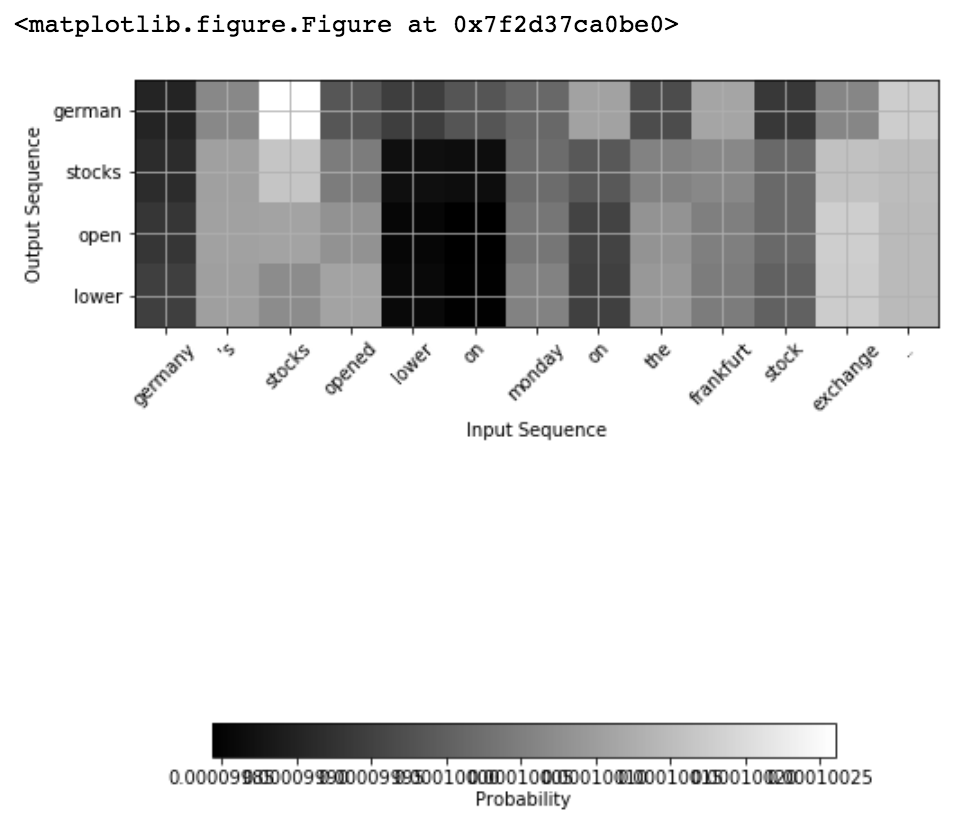

In [153]:
#plot the attion model
text="germany 's stocks opened lower on monday on the frankfurt stock exchange ."
test_data_vector_article=x_test[4219:4220,:]
idx2word_title=idx2word_summary
viz.attention_map(text,test_data_vector_article,idx2word_title)

### 3)

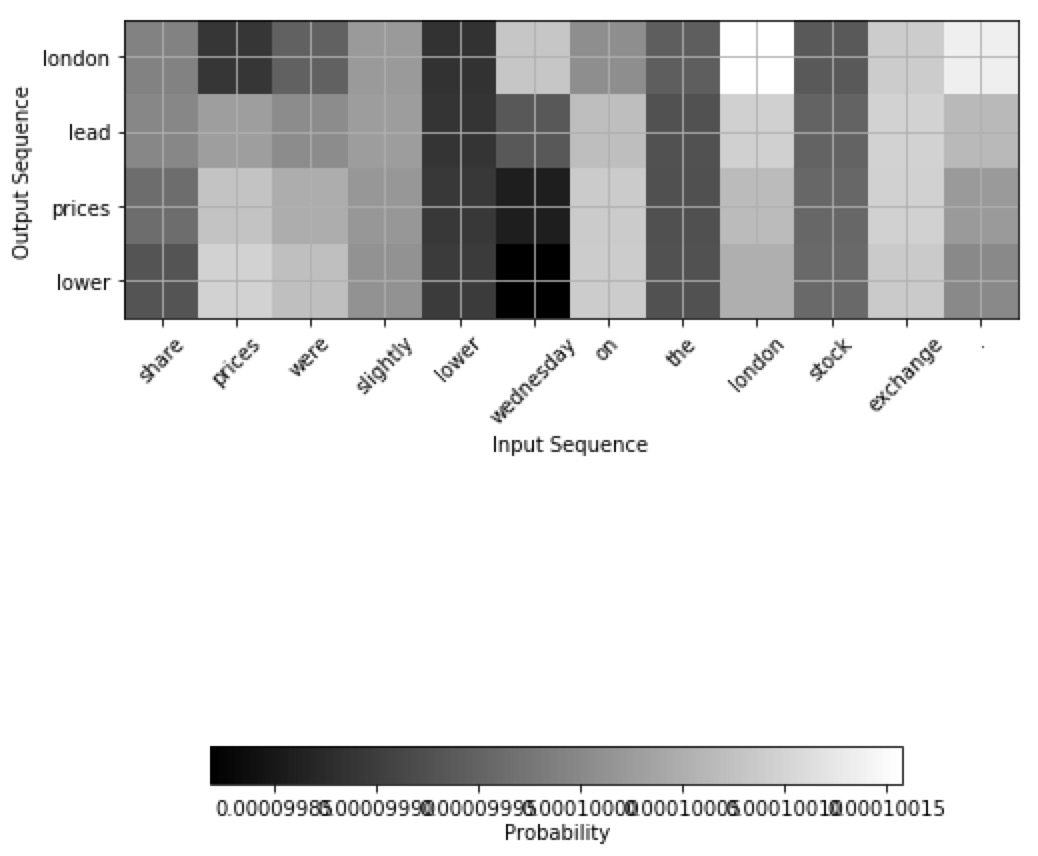

In [155]:
#plot the attion model
text="share prices were slightly lower wednesday on the london stock exchange ."
test_data_vector_article=x_test[333:334,:]
idx2word_title=idx2word_summary
viz.attention_map(text,test_data_vector_article,idx2word_title)

### 4)

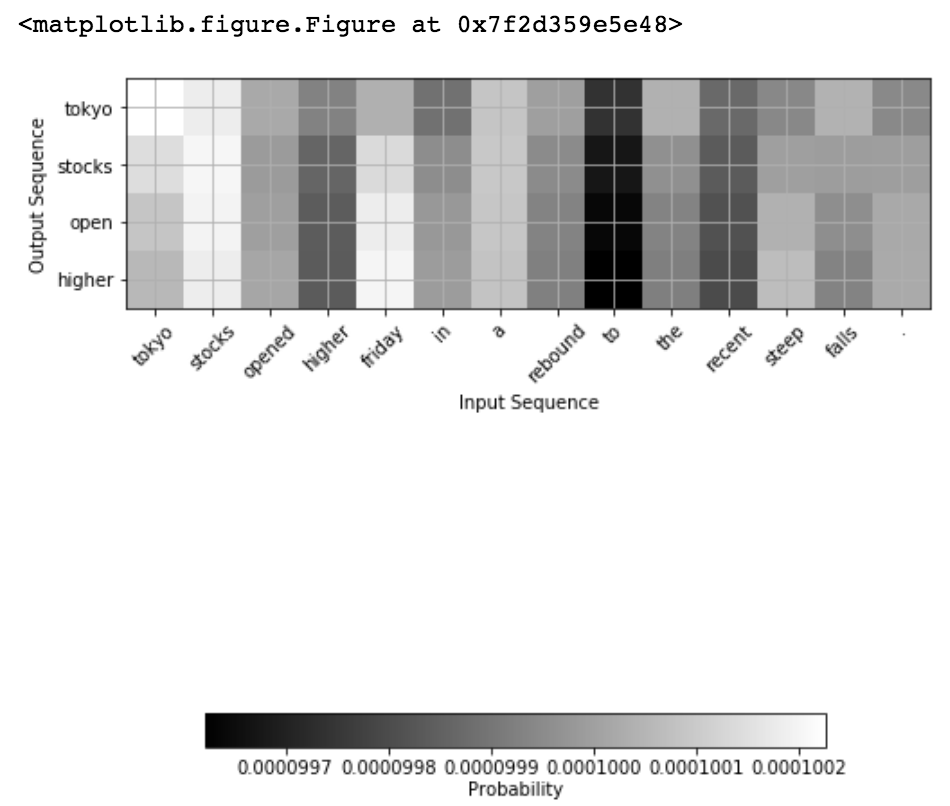

In [157]:
#plot the attion model
text="tokyo stocks opened higher friday in a rebound to the recent steep falls ."
test_data_vector_article=x_test[4120:4121,:]
idx2word_title=idx2word_summary
viz.attention_map(text,test_data_vector_article,idx2word_title)

### 5)

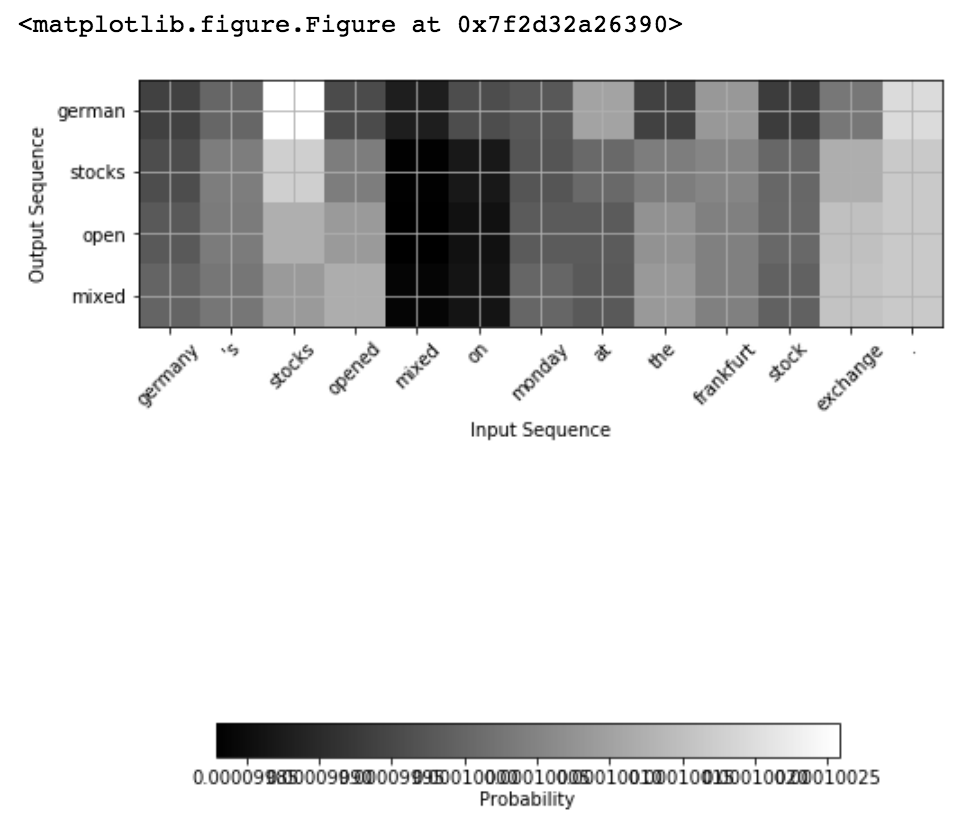

In [158]:
#plot the attion model
text="germany 's stocks opened mixed on monday at the frankfurt stock exchange ."
test_data_vector_article=x_test[4089:4090,:]
idx2word_title=idx2word_summary
viz.attention_map(text,test_data_vector_article,idx2word_title)

### Bad Sentences

### 1)

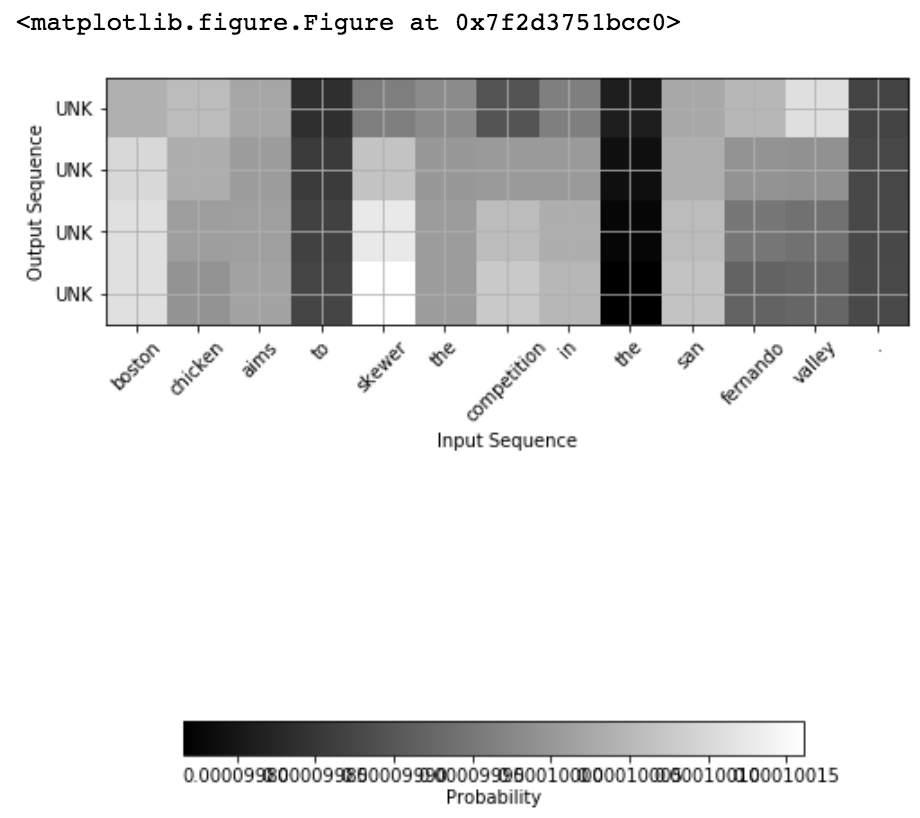

In [159]:
#plot the attion model
text="boston chicken aims to skewer the competition in the san fernando valley ."
test_data_vector_article=x_test[3878:3879,:]
idx2word_title=idx2word_summary
viz.attention_map(text,test_data_vector_article,idx2word_title)

#### 2)

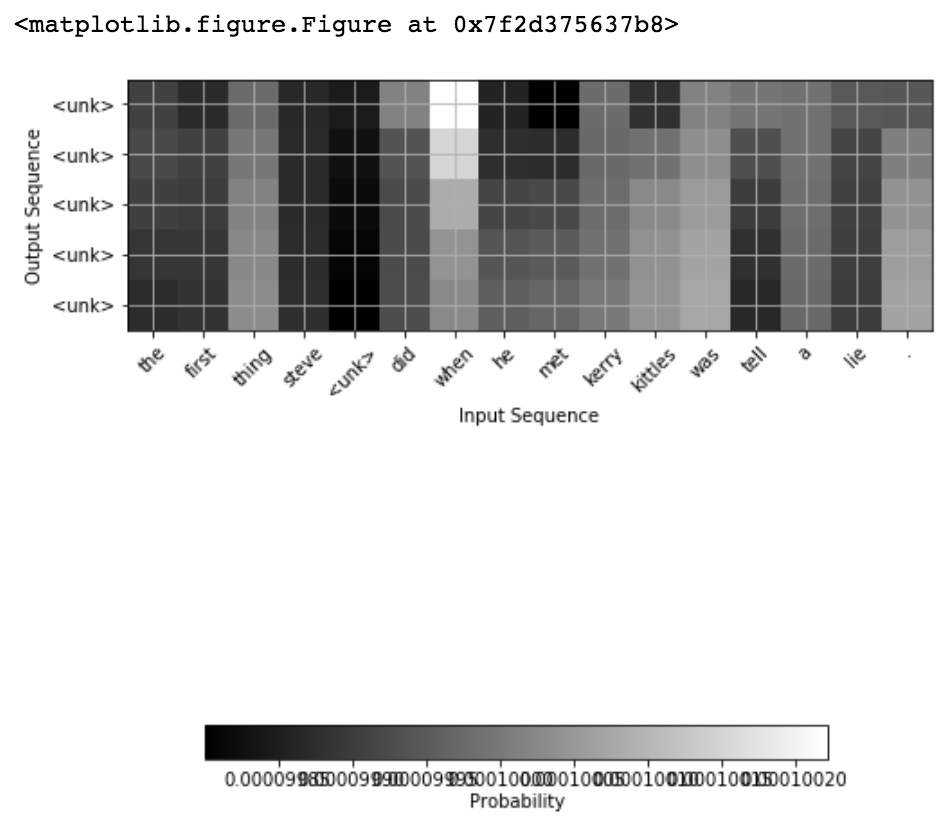

In [160]:
#plot the attion model
text="the first thing steve <unk> did when he met kerry kittles was tell a lie ."
test_data_vector_article=x_test[3576:3577,:]
idx2word_title=idx2word_summary
viz.attention_map(text,test_data_vector_article,idx2word_title)

#### 3)

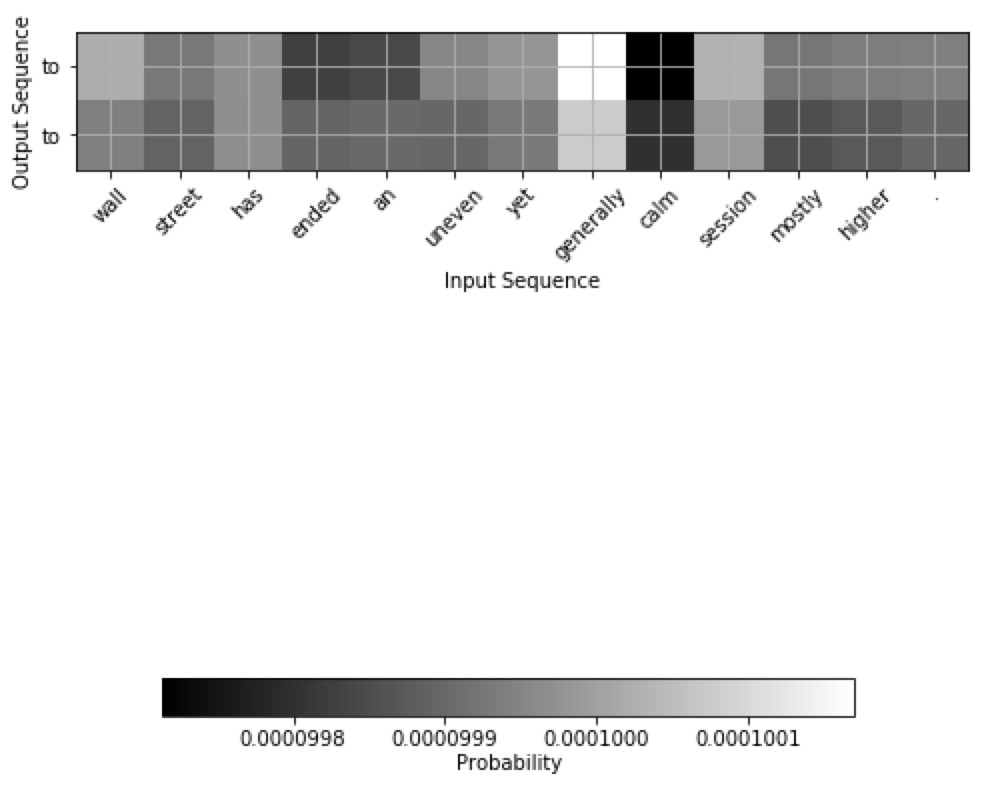

In [161]:
#plot the attion model
text="wall street has ended an uneven yet generally calm session mostly higher ."
test_data_vector_article=x_test[2241:2242,:]
idx2word_title=idx2word_summary
viz.attention_map(text,test_data_vector_article,idx2word_title)

#### 4)

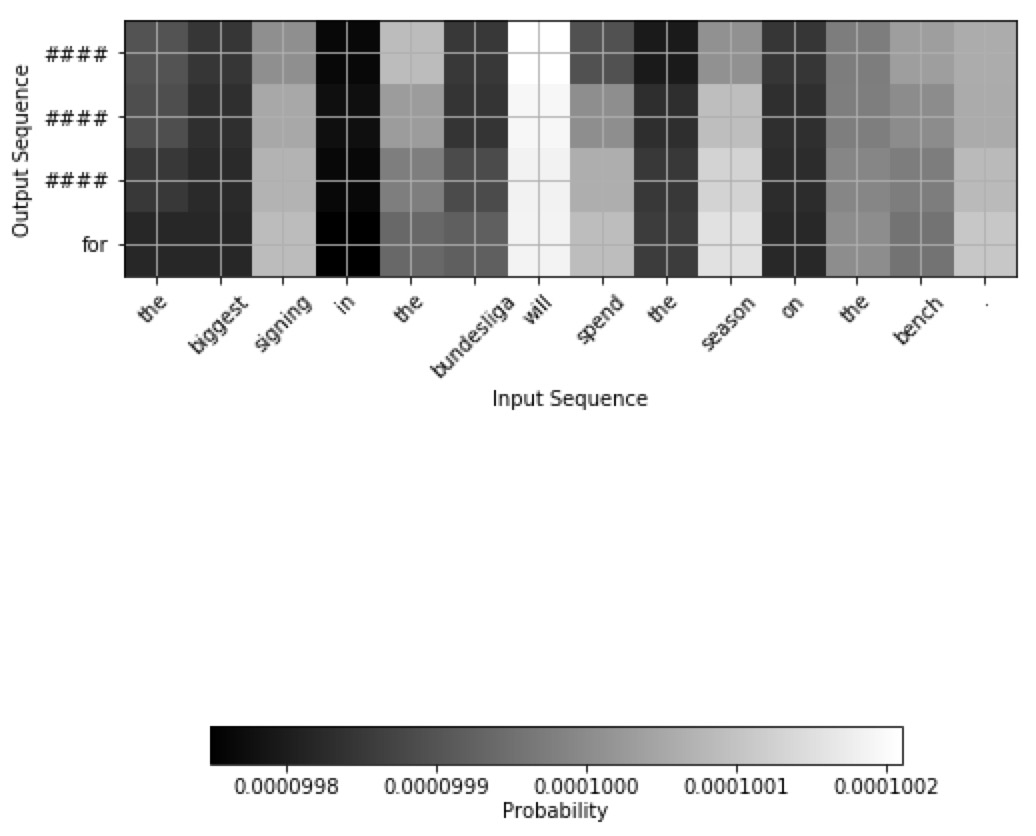

In [162]:
#plot the attion model
text="the biggest signing in the bundesliga will spend the season on the bench ."
test_data_vector_article=x_test[2179:2180,:]
idx2word_title=idx2word_summary
viz.attention_map(text,test_data_vector_article,idx2word_title)

#### 5)

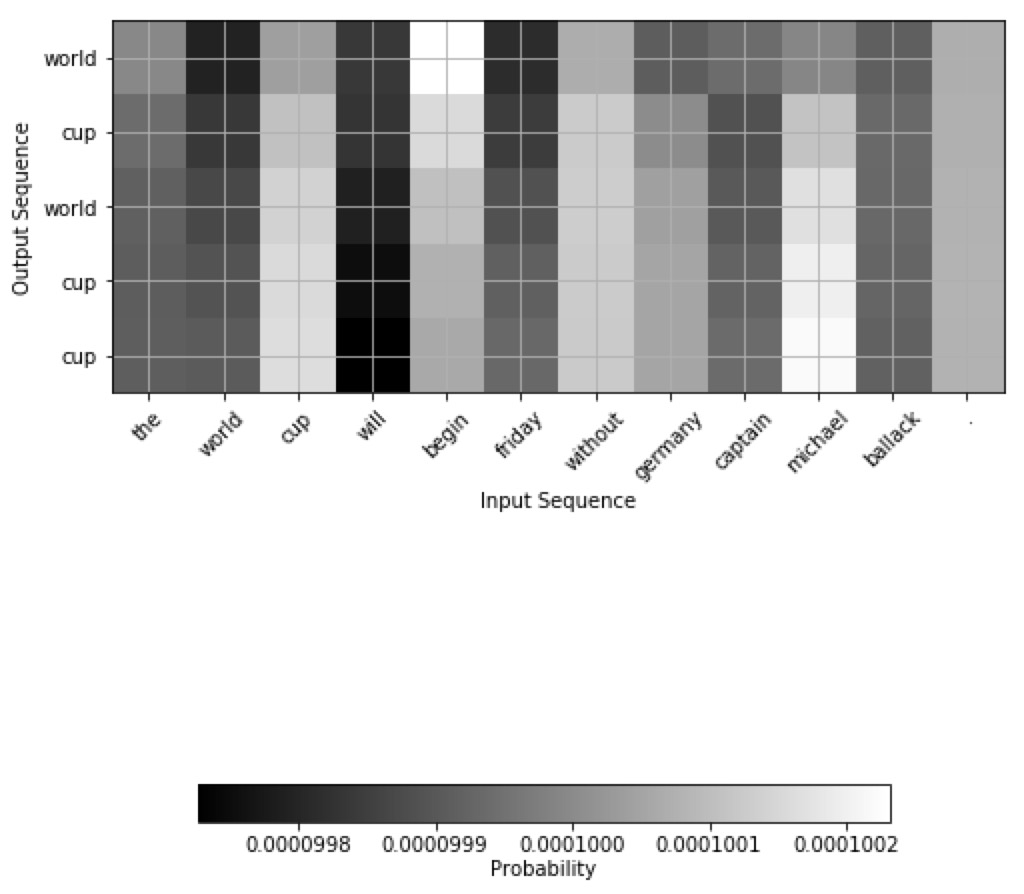

In [163]:
#plot the attion model
text="the world cup will begin friday without germany captain michael ballack ."
test_data_vector_article=x_test[407:408,:]
idx2word_title=idx2word_summary
viz.attention_map(text,test_data_vector_article,idx2word_title)

### Random

#### 1)


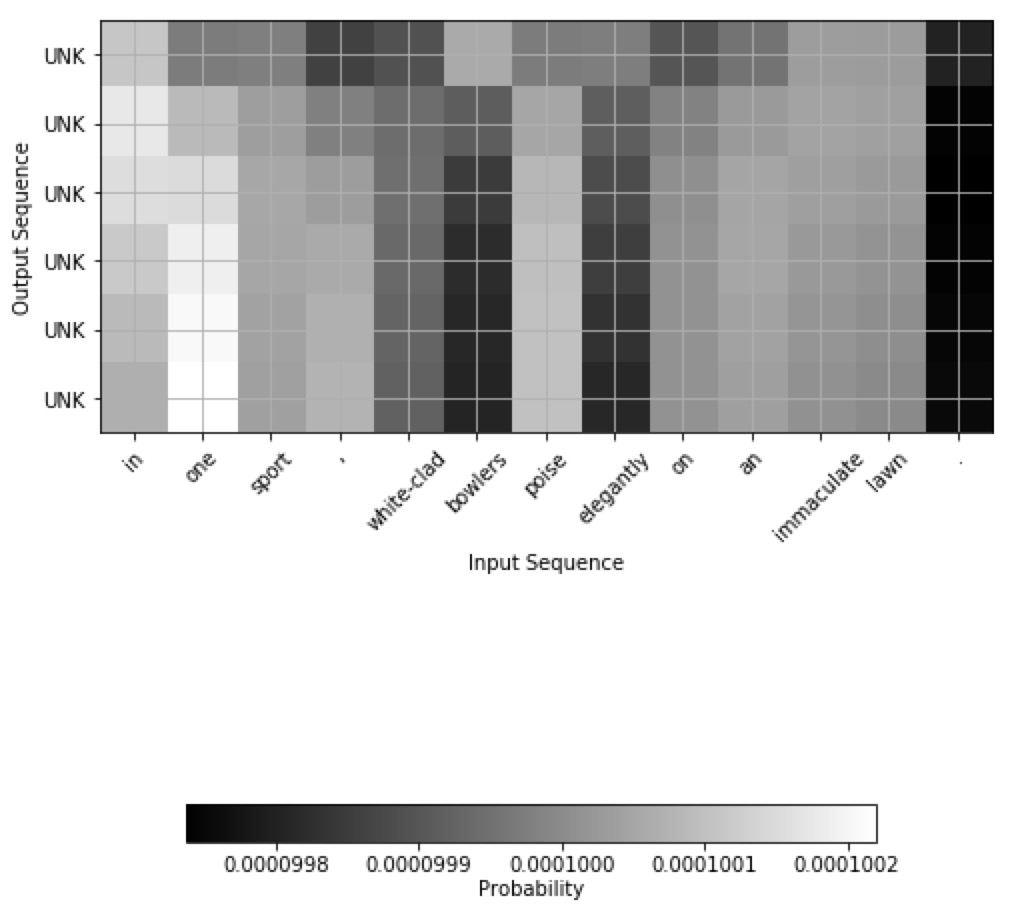

In [165]:
#plot the attion model
text="in one sport , white-clad bowlers poise elegantly on an immaculate lawn ."
test_data_vector_article=x_test[10:11,:]
idx2word_title=idx2word_summary
viz.attention_map(text,test_data_vector_article,idx2word_title)

#### 2)

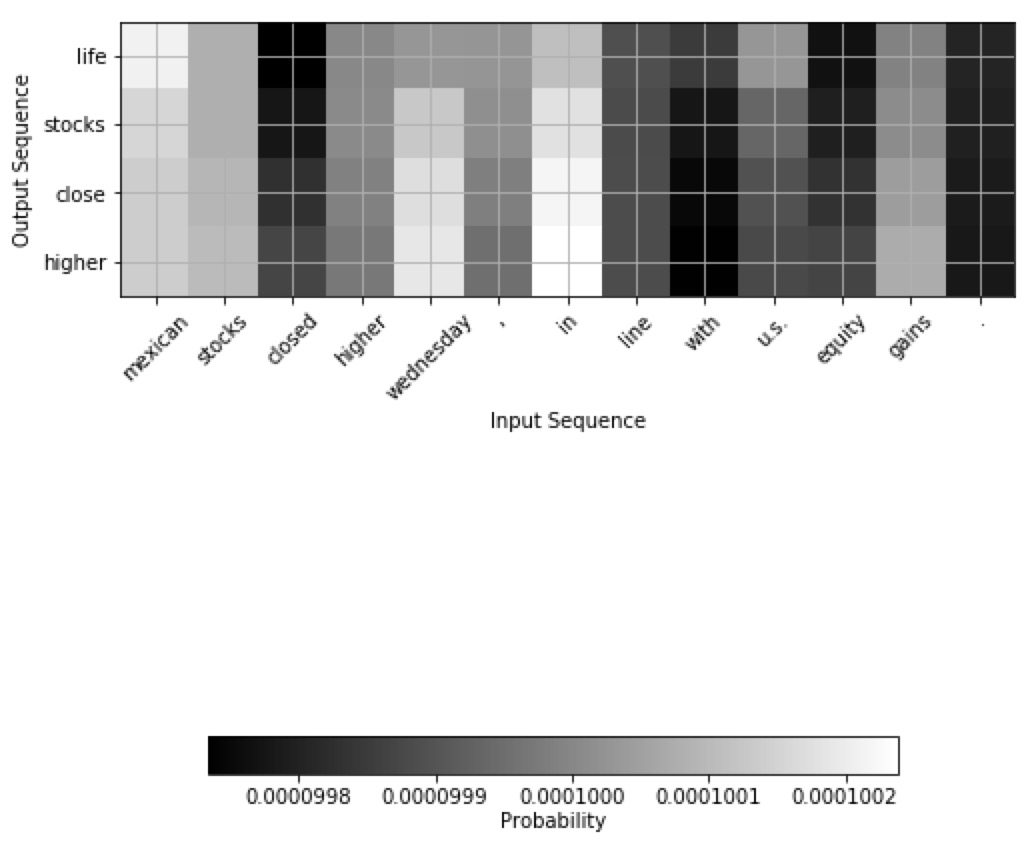

In [166]:
#plot the attion model
text="mexican stocks closed higher wednesday , in line with u.s. equity gains ."
test_data_vector_article=x_test[285:286,:]
idx2word_title=idx2word_summary
viz.attention_map(text,test_data_vector_article,idx2word_title)

#### 3)

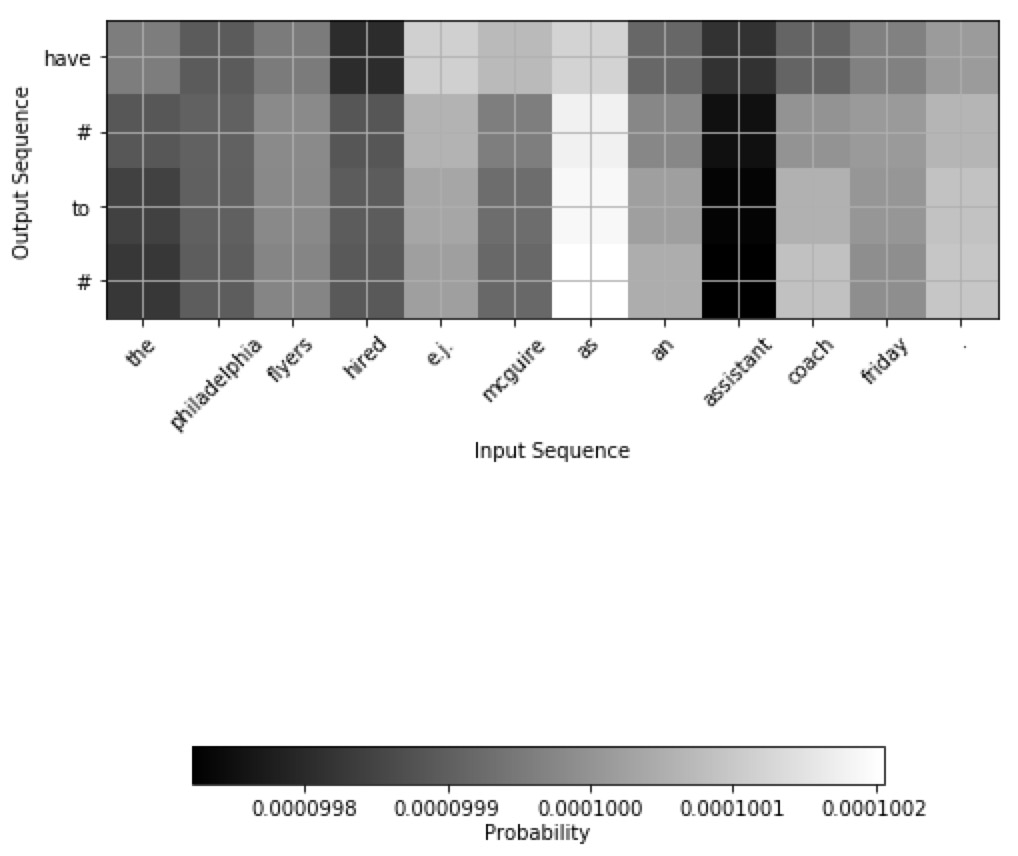

In [167]:
#plot the attion model
text="the philadelphia flyers hired e.j. mcguire as an assistant coach friday ."
test_data_vector_article=x_test[339:340,:]
idx2word_title=idx2word_summary
viz.attention_map(text,test_data_vector_article,idx2word_title)

#### 4)

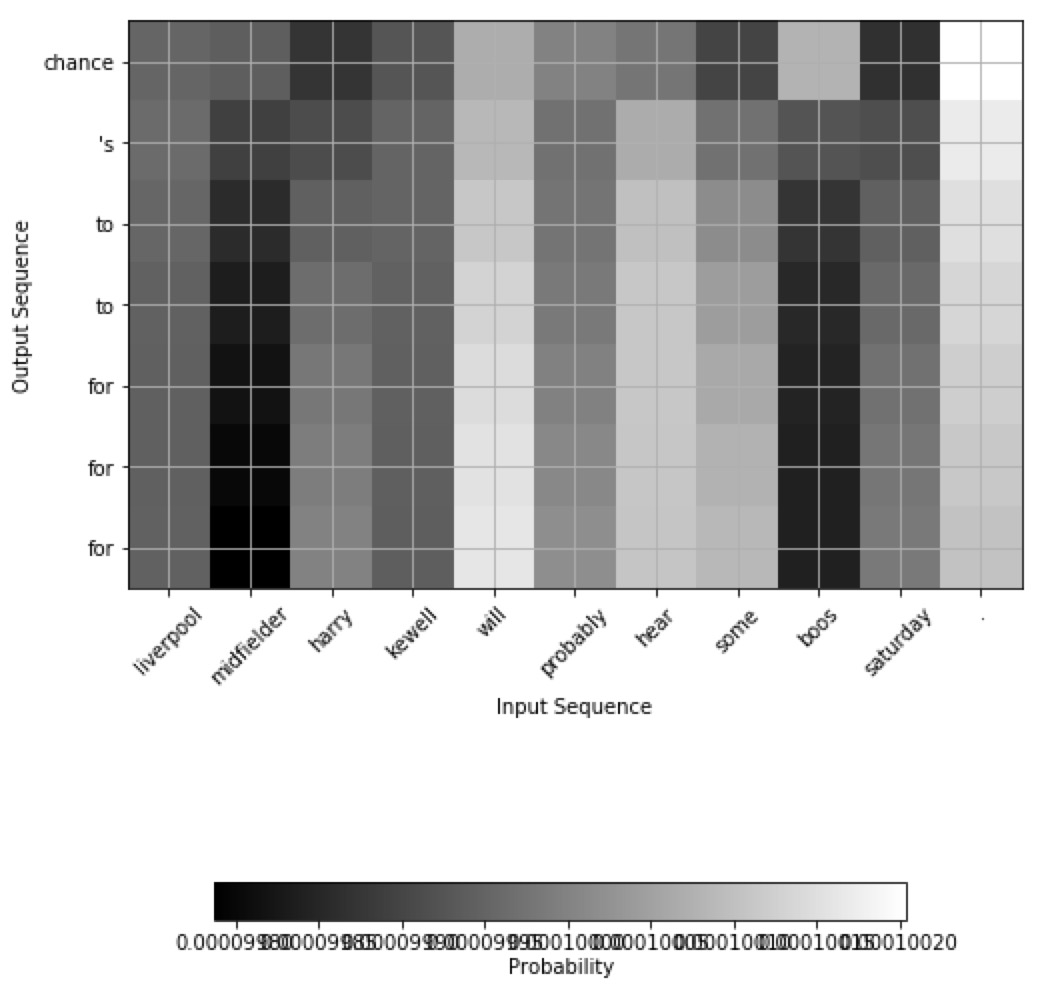

In [168]:
#plot the attion model
text="liverpool midfielder harry kewell will probably hear some boos saturday ."
test_data_vector_article=x_test[2:3,:]
idx2word_title=idx2word_summary
viz.attention_map(text,test_data_vector_article,idx2word_title)

#### 5)

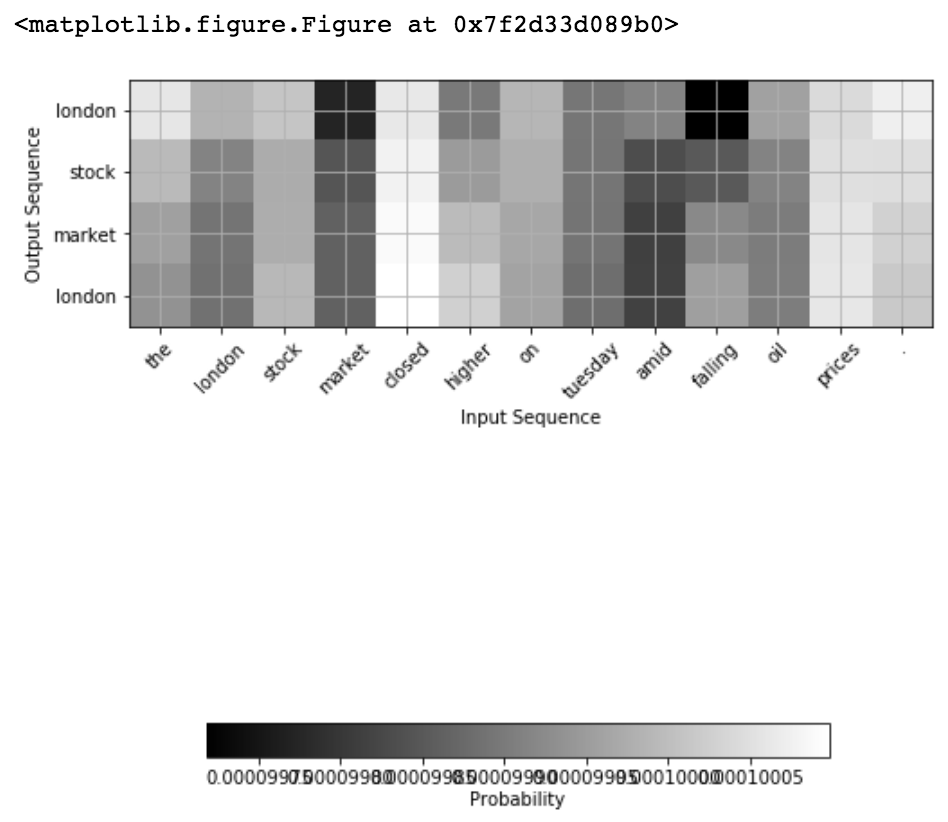

In [169]:
#plot the attion model
text="the london stock market closed higher on tuesday amid falling oil prices ."
test_data_vector_article=x_test[4216:4217,:]
idx2word_title=idx2word_summary
viz.attention_map(text,test_data_vector_article,idx2word_title)

### Description

As you can see above, it shows an example of this distribution probability as a summary is generated. given the input word, the probability of an output will be representing in a color. If the color is lighter, and the probability will be higher. The system tries to extract the important values from the input sentences. It works better if there is a City name or Country name in the sentence, then it is usually extracted and used in the summarization part. Based on the strong relationship between "Friday" with "higher" and "stocks" with "German", this kinds of relationships should happen very frequent in the training dataset, which causes the high probability in the testing dataset.

## table

### Good Sentences

I(1): germany 's stocks opened mixed on friday at the frankfurt stock exchange.

   G:  german stocks open mixed

   A:  german stocks open mixed

   A+: german stocks open mixed


I(2): germany 's stocks opened lower on monday on the frankfurt stock exchange .

  G:  german stocks open lower

  A:  german stocks open manchester

 A+: german stocks open lower


I(3): share prices were slightly lower wednesday on the london stock exchange .

  G:  stock prices slip in london

  A:  london share prices game at

 A+: london lead prices lower


I(4): tokyo stocks opened higher friday in a rebound to the recent steep falls .

  G:  tokyo stocks open higher

  A:  tokyo stocks open lower dollar up against yen

 A+: tokyo stocks open higher


I(5): germany 's stocks opened mixed on monday at the frankfurt stock exchange .

  G:  german stocks open mixed

  A:  german stocks open mixed

 A+: german stocks open mixed



### Bad Sentences

I(1): boston chicken aims to skewer the competition in the san fernando valley .

  G:  boston market plans restaurant expansion

  A:  UNK 's to in in in

 A+:UNK UNK UNK UNK



I(2): the first thing steve < unk > did when he met kerry kittles was tell a lie .

  G:  kittles named big east player of the year

  A:  UNK the to in for for for

 A+: < unk > < unk > < unk > < unk > < unk >



I(3): wall street has ended an uneven yet generally calm session mostly higher .

  G:  wall street extends dow s rally to third day

  A:  wall street gore mixed

 A+: to to


I(4): the biggest signing in the bundesliga will spend the season on the bench .

  G:  klinsmann heads crop of new coaches in bundesliga

  A:  UNK 's to to

 A+:#### #### #### for


I(5): the world cup will begin friday without germany captain michael ballack .

  G:  ballack to miss opening world cup match ; rooney 's in cisse 's out

  A:  war 's cup cup to to to of world

 A+: 407 world cup world cup cup



### Random

I(1): in one sport , white-clad bowlers poise elegantly on an immaculate lawn .

  G:  lawn bowls and tenpin bowling distant companions at commonwealth games

  A:  UNK UNK to to of

 A+: UNK UNK UNK UNK UNK UNK




I(2): mexican stocks closed higher wednesday , in line with u.s. equity gains .

  G:  stocks rise in mexico argentina ; finish flat in brazil venezuela

  A:  stocks close higher in in america

 A+: life stocks close higher


I(3): the philadelphia flyers hired e.j. mcguire as an assistant coach friday .

  G:  flyers hire mcguire as assistant

  A:  UNK 's to to to to in in

 A+: have # to #


I(4): liverpool midfielder harry kewell will probably hear some boos saturday .

  G:  kewell ready for jeers when liverpool hosts leeds

  A:  UNK 's to to to to for

 A+: chance 's to to for for for



I(5): the london stock market closed higher on tuesday amid falling oil prices .

  G:  london key market information

  A:  london stock market closes

 A+: london stock market london



## Analysis of errors and comparisons

As you can see, the good summarizations for both models are usually produced by extraction rather than abstraction, which means that systems select units (words, sentences, paragraphs, etc) that contain the essence of the document and then assemble them.  Instead, by looking at the bad sentences, when the title is very different from the article, attention does not work well by doing abstraction and making generation and compressing.	 

The problem that attention system most have is that repetition of words, especially for the word "unk". It makes sense for me since we cut the vocabulary size due to the computation complexity, which can cause a lot of words are be categorizes as an "UNK" in the training dataset since they are not in training dataset.  Also, it sometimes predicts some unrelated words

Compared to no attention based model, we found that attention model can predict more complicated long sentence better. However, for the short term sentence, no attention based model sometime has better performance. Plus, the computation for attention based model is much more complicated.


## Proposal for addressing error

First, my problem that I found is that there are a lot of repetitions of words, especially for the word "unk". It gives meaningless values. One of the reason that I found is that I didn't use all the vocabularies. Instead, I cut the vocabulary size down due to the computation complexity and long time to train the models. Also, I have tested it out, when I increased the vocabulary size, the rouge score will increase too. It happens to the numbers of epochs too. In order to avoid overfitting, I also performed cross validation.  

One thing that we need to consider is to get a better GPU to train larger vocabulary size. However, this cannot be usually achieved due to the limited technology. Therefore, I am thinking about modifying the max length. Instead of using the maximum length from both x and y dataset, which gives us a very sparse matrix to train, we may cut the max length to see whether it will give better result. Since there will may be a case, except the max length vector with 32, other vectors only have at most 15 words, which will make the model inaccurate and try to focus on predicting those 0 value.

Another way we can think about is to use a pre-training methods since thinking about the training datasets around the world, our training dataset is considered as a small dataset, so pre-training all the parameters of the model and utilize all available text can help to improve the rouge scores. 


# Unidirectional LSTM Encoder Decoder With Attention and Beam Search (Extra Credit)

The models that you implemented till now had greedy decoder. Now implement a Decoder with Beam Search and show improved results